# Auxotrophies and Interactomes in Mixed Culture of Freshwater Bacteria

## Project Overview

This notebook describes reverse ecological analysis of a mixed culture from Lake Grosse Fuchskuhle. For additional details, please see:

Garcia, S. L., Buck, M., McMahon, K. D., Grossart, H.-P., Eiler, A., & Warnecke, F. (2015). Auxotrophy and intra-population complementary in the “interactome” of a cultivated freshwater model community. Molecular Ecology, 24(17), 4449–4459. http://doi.org/10.1111/mec.13319

## Background and Theory

For an overview of the theory underlying this pipeline, please the notebook `masterNotebook` in the `master` branch of this repo. In the interest of brevity, this notebook focuses on carrying out the workflow, not the theory.

## Obtaining and Processing Metabolic Network Reconstructions from KBase

Reverse ecology analysis relies on metabolic network reconstructions for an organism of interest. KBase (http://kbase.us) is a powerful resource for obtaining genome-scale network reconstructions for microbial genomes. These reconstructions are distributed as SBML files, which must be processed prior to reverse ecology analysis. This section describes how to obtain reconstructions from KBase, and how to process them.

### Obtaining and Preparing SBML Files

Genomes (as fasta files) for your organisms of interest can be pushed from your computer to KBase. Once there, a KBase Narrative (iPython notebook) can be used to build reconstructions for your genomes. 

The script `loadGenomes` pushes these genomes to the KBase narrative created for this project.
* KBase Narrative: [Model Building for FNE-F8 Mixed Culture MAGs](https://narrative.kbase.us/narrative/ws.12305.obj.1)
* Workspace Browser: [joshamilton:1452727482251](https://narrative.kbase.us/functional-site/#/ws/objects/joshamilton:1452995633835)

I then ran the "Annotate Contigs" and "Build Metabolic Model" KBase apps for each genome. I downloaded the annotated genomes (Genbank format) and models (SBML and tsv formats). Files are stored in:
* `refGenomes` - genomes and annotations in a variety for formats
* `sbml` - metabolic models in SBML and 'tsv' formats. Pre- and post-processed versions (see below).

Once the genomes were downloaded, I further converted the Genbank-formatted genomes to fasta nucleotide (ffn), fasta amino acid (ffa), and gff format. Using the following scripts:
* `concatGbk.sh` - concatenate gbk files for each contig into a single file for each genome
* `kBaseGenbankToFasta.py` - convert gbk to ffn and ffa format
* `kBaseGenbankToGff.py` - convert gbk to gff format
* `cleanUpGFF.pl` - remove extra comments from gff files

## Processing SBML Files

Reconstructions from KBase require further processing before they are suitable for use in reverse ecology. The function below does a number of things:

1. Reformat gene locus tags
2. Remove biomass, exchange, spontaneous, DNA/RNA biosynthesis reactions and their corresponding genes
3. Import metabolite formulas
4. Check mass- and charge-balancing of reactions in the reconstruction
5. Remove trailing 0s from reaction and metabolite names

The post-processing has a major shortcoming. When KBase detects that one or more subunits of a complex are present, it creates a "full" GPR by adding 'Unknown' genes for the other subunits. CobraPy currently lacks functions to remove the genes. As such, these model should not be used to perform any simulations which rely on GPRs.

As output, the code returns processed SBML files in the `sbml/processed` folder. Also returns a summary of the model sizes, in the `data` folder.

The first chunk of code identifies imports the Python packages necessary for this analysis.

In [2]:
# Import special features for iPython
import sys
sys.path.append('../Python')
import matplotlib
%matplotlib inline

# Import Python modules 
# These custom-written modules should have been included with the package
# distribution. 
import graphFunctions as gf
import sbmlFunctions as sf
import seedFunctions as ef
import metadataFunctions as mf

# Define local folder structure for data input and processing.
externalDataDir = 'externalData'
rawModelDir = 'sbml/raw'
processedDataDir = 'sbml/processed'
summaryStatsDir = 'data'

Then we call a function which processes each SBML file and preps it for analysis.

In [ ]:
sf.processSBMLforRE(rawModelDir, processedDataDir, summaryStatsDir)

## Converting SBMLs for Use with Reverse Ecology

My reverse ecology pipeline operates on metabolic network recontructions which are represented as metabolic network graphs. This section converts the reconstruction from SBML format to graph format. Briefly, the network reconstruction is converted to a directed graph and extracts the largest connected component. This component is then subject to reverse ecology analysis.

In [3]:
# Import the list of models
dirList = mf.getDirList('../'+processedDataDir)
numSubDir = len(dirList)

# Convert to a network graph
modelStatArray = sf.dirListToAdjacencyList(dirList, processedDataDir, summaryStatsDir)

# Reduce to the largest component
graphStatArray, diGraphStatArray = gf.computeGraphStats(dirList, summaryStatsDir)
reducedGraphStatArray = gf.reduceToLargeComponent(dirList, summaryStatsDir)

Converting SBML files to adjacency lists
Computing graph statistics
Reducing to largest component


## Computing Seed Sets

This section computes the seed sets for each genome. Formally, the seed set of a network is the minimal subset of compounds (nodes) that cannot be synthesized from other compounds in the network, and whose presence in the environment permits the production of all other compounds in the network. In other words, the seed set of a network is a set of nodes from which all other nodes can be reached.

Mathematically, seed sets are source components in the condensation of the original network graph. Seed compounds can also have weights associated with them. For a seed compound belonging to a source component of size n, its weight is 1/n. These compounds are metabolically "equivalent," in that any one of them can be synthesized from any of the others.

Thus, the seed set detection algorithm contains four steps.

* Identify the SCCs of the (directed) network graph
* Use the SCCs to derive the condensation of the original graph
* Identify source components in the condensation
* Expand each source component of the condensation into its original node

The code below performs the four steps shown above for the metabolic network graph of each genome. The seed compounds for each graph are written to a file, with each line in the file containing a set of equivalent seed compounds.

In [4]:
seedSetList = gf.computeSeedSets(dirList, summaryStatsDir)

Computing seed sets


## Reverse Ecology Metrics

Reverse ecology theoreticians have developed a number of metrics which provide qualitative insights into the ecology of microorganisms. This section is concerned with computing two of those metrics, metabolic competition and metabolic complementarity.

Metabolic competition represents the similarity in two organisms' nutritional profiles, and represents the potential for competition between the two organisms. For two organisms A and B, the metabolic competition index is calculated as the fraction of compounds in A's seed set that are also present in B's seed set. This index provides an upper bound for the amount of competition species A could encounter from species B.

Metabolic complementarity represents the complementarity in two organisms’ nutritional profiles, and represents the potential for syntrophy between A and B. For two organisms A and B, the metabolic complementarity index is calculated as the fraction of compounds in A's seed set that are present in B's metabolic network, but are not a part of B's seed set (e.g, B's 'non-seed' compounds). This index provides an upper bound for the potential for syntrophic interactions between A and B.

The functions below compute the competition and complementarity scores between all pairs of genomes and visualize the results as a heatmap.

/Library/Python/2.7/site-packages/matplotlib/figure.py:397 UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure


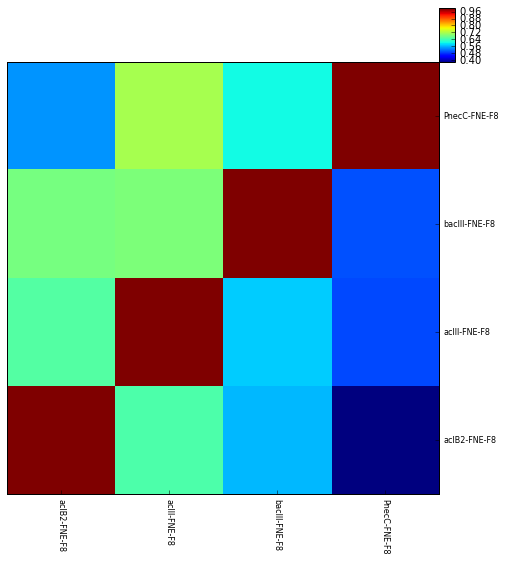

In [5]:
# Competition
genomeDir = 'data' # This function can operate on models of individual or merged genomes. Specify the proper input directory.

metabCompeteDF = ef.computeMetabCompete(dirList, genomeDir, summaryStatsDir)
ef.plotDataFrame(metabCompeteDF, dirList, summaryStatsDir, 'metabolicCompetition.png')

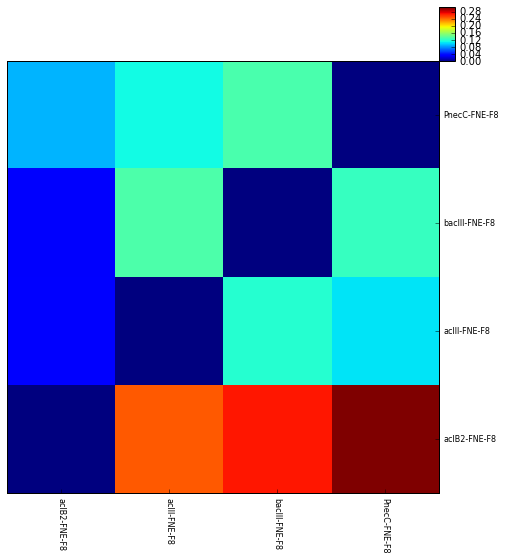

In [6]:
# Complementarity
genomeDir = 'data' # This function can operate on models of individual or merged genomes. Specify the proper input directory.

metabComplementDF = ef.computeMetabComplement(dirList, genomeDir, summaryStatsDir)
ef.plotDataFrame(metabComplementDF, dirList, summaryStatsDir, 'metabolicComplementarity.png')

## TO DO

I would like to write some additional analysis to compare these results to the manual reconstruction.

1. The functions above identify metabolites for which organisms may compete, and which may be shared (complementarity), but they're not actually recorded anywhere. I want to examine complementarity metabolites to identify potential interactions (Figure 4).

2. An alternative approach to complementarity. I can merge genomes for all pairs, triplets, etc of genomes in the community. By comparing seed sets for individual vs. merged genomes, I can also identity metabolites which would be shared by community members. I'm not sure if the results would be any different than looking at complementary metabolites alone.